In [1]:
import os
import numpy as np
import argparse
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from lib.utils.tools import *
from lib.utils.learning import *
from lib.utils.utils_data import flip_data
from lib.data.dataset_wild import WildDetDataset
from lib.utils.vismo import render_and_save

In [2]:
import easydict
import getpass

user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose/'.format(user)
video = '30_M160A_3'
out_path = 'output/aihub_30/FT_MB_ft_h36m_MB_ft_aihub_30_{}'.format(video)
vid_path = alphapose_root + 'examples/aihub_result/res_{}/test.mp4'.format(video)
json_path = alphapose_root + 'examples/aihub_result/res_{}/alphapose-results.json'.format(video)

opts = easydict.EasyDict({
    "config": "configs/pose3d/MB_ft_aihub_30.yaml",
    "evaluate": 'checkpoint/pose3d/FT_MB_ft_h36m_MB_ft_aihub_30/best_epoch.bin',
    "selection": 'best_epoch.bin',
    "clip_len": 243,
    "vid_path": vid_path,
    "json_path": json_path,
    "out_path": out_path,
    "pixel": False,
    "focus": None
    })
args = get_config(opts.config)

In [3]:
model_backbone = load_backbone(args)
if torch.cuda.is_available():
    model_backbone = nn.DataParallel(model_backbone)
    model_backbone = model_backbone.cuda()

print('Loading checkpoint', opts.evaluate)
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_backbone.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos = model_backbone
model_pos.eval()
testloader_params = {
          'batch_size': 1,
          'shuffle': False,
          'num_workers': 8,
          'pin_memory': True,
          'prefetch_factor': 4,
          'persistent_workers': True,
          'drop_last': False
}

Loading checkpoint checkpoint/pose3d/FT_MB_ft_h36m_MB_ft_aihub_30/best_epoch.bin


In [4]:
vid = imageio.get_reader(opts.vid_path,  'ffmpeg')
fps_in = vid.get_meta_data()['fps']
vid_size = vid.get_meta_data()['size']
os.makedirs(opts.out_path, exist_ok=True)

In [5]:
if opts.pixel:
    # Keep relative scale with pixel coornidates
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, vid_size=vid_size, scale_range=None, focus=opts.focus)
else:
    # Scale to [-1,1]
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, scale_range=[1,1], focus=opts.focus)

test_loader = DataLoader(wild_dataset, **testloader_params)

In [6]:
results_all = []
with torch.no_grad():
    for batch_input in tqdm(test_loader):
        N, T = batch_input.shape[:2]
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
        if args.no_conf:
            batch_input = batch_input[:, :, :, :2]
        if args.flip:    
            batch_input_flip = flip_data(batch_input)
            predicted_3d_pos_1 = model_pos(batch_input)
            predicted_3d_pos_flip = model_pos(batch_input_flip)
            predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip) # Flip back
            predicted_3d_pos = (predicted_3d_pos_1 + predicted_3d_pos_2) / 2.0
        else:
            predicted_3d_pos = model_pos(batch_input)
        if args.rootrel:
            predicted_3d_pos[:,:,0,:]=0                    # [N,T,17,3]
        else:
            predicted_3d_pos[:,0,0,2]=0
            pass
        if args.gt_2d:
            predicted_3d_pos[...,:2] = batch_input[...,:2]
        results_all.append(predicted_3d_pos.cpu().numpy())
results_all = np.hstack(results_all) # (B, N, 17, 3)
results_all = np.concatenate(results_all) # (BxN, 17, 3) # normalized 3d pose

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


In [7]:
results_all.shape

(144, 17, 3)

100%|██████████| 144/144 [00:13<00:00, 10.69it/s]


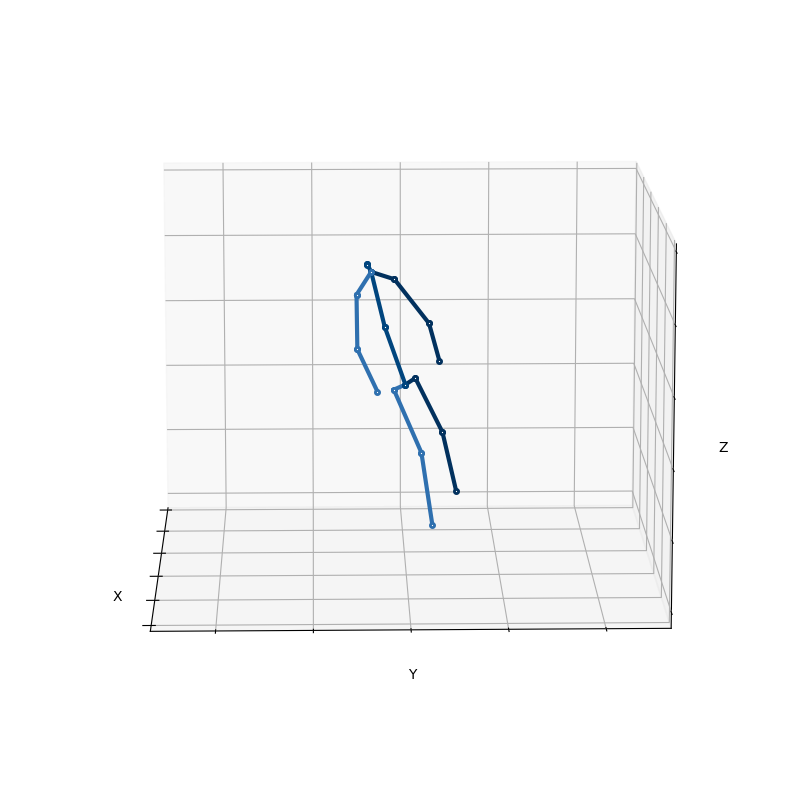

In [18]:
render_and_save(results_all, '%s/X3D.mp4' % (opts.out_path), keep_imgs=False, fps=fps_in)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from custom_codes.test_utils import *

plt.switch_backend('TkAgg')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [18]:
fig = visualize_3d_pose([results_all[50]*1000])
fig.show()